In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df = pd.read_csv('AQI_HaNoi_Updated.csv')
df.head()

,date,pm25,pm10,o3,no2,so2,co,year,AQI_pm25,AQI_pm10,AQI_o3,AQI_no2,AQI_so2,AQI_co,AQI
0,2019-01-01,36.0,21.0,12.0,22.0,10.0,9.0,NaN,72.0,21.0,3.7500,11.0,4.0,45.0,72.0
1,2019-01-02,34.0,46.0,23.0,13.0,10.0,10.0,NaN,68.0,46.0,7.1875,6.5,4.0,50.0,68.0
2,2019-01-03,47.0,35.0,15.0,19.0,8.0,9.0,NaN,94.0,35.0,4.6875,9.5,3.2,45.0,94.0
3,2019-01-04,53.0,39.0,21.0,15.0,13.0,3.0,NaN,105.0,39.0,6.5625,7.5,5.2,15.0,105.0
4,2019-01-05,40.0,28.0,13.0,12.0,8.0,9.0,NaN,80.0,28.0,4.0625,6.0,3.2,45.0,80.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1979 non-null   object 
 1   pm25      1979 non-null   float64
 2   pm10      1979 non-null   float64
 3   o3        1979 non-null   float64
 4   no2       1979 non-null   float64
 5   so2       1979 non-null   float64
 6   co        1979 non-null   float64
 7   year      1778 non-null   float64
 8   AQI_pm25  1979 non-null   float64
 9   AQI_pm10  1979 non-null   float64
 10  AQI_o3    1979 non-null   float64
 11  AQI_no2   1979 non-null   float64
 12  AQI_so2   1979 non-null   float64
 13  AQI_co    1979 non-null   float64
 14  AQI       1979 non-null   float64
dtypes: float64(14), object(1)
memory usage: 232.0+ KB


In [4]:
df.AQI.min()

15.0

In [5]:
cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI']

In [6]:
df = df[cols]
df.head()

,pm25,pm10,o3,no2,so2,co,AQI
0,36.0,21.0,12.0,22.0,10.0,9.0,72.0
1,34.0,46.0,23.0,13.0,10.0,10.0,68.0
2,47.0,35.0,15.0,19.0,8.0,9.0,94.0
3,53.0,39.0,21.0,15.0,13.0,3.0,105.0
4,40.0,28.0,13.0,12.0,8.0,9.0,80.0


In [7]:
# fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(10,10))
# for i, ax in enumerate(axes.flatten()):
#     data = df[df.columns[i]]
#     ax.plot(data, color='blue', linewidth=1)
#     # Decorations
#     ax.set_title(df.columns[i])
#     ax.xaxis.set_ticks_position('none')
#     ax.yaxis.set_ticks_position('none')
#     ax.spines["top"].set_alpha(0)
#     ax.tick_params(labelsize=6)

# plt.tight_layout();

### 7. Cointegration Test ###

In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
pm25   ::  539.61    > 111.7797  =>   True
pm10   ::  380.31    > 83.9383   =>   True
o3     ::  244.53    > 60.0627   =>   True
no2    ::  137.17    > 40.1749   =>   True
so2    ::  67.51     > 24.2761   =>   True
co     ::  26.44     > 12.3212   =>   True
AQI    ::  1.86      > 4.1296    =>   False


In [9]:
# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR  

time_series = df[cols]
train_data = time_series[:int(0.9*len(time_series))]
test_data = time_series[int(0.9*len(time_series)):]

### 9. Check for Stationarity and Make the Time Series Stationary ###

In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [11]:
# ADF Test on each column
for name, column in train_data.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pm25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6424
 No. Lags Chosen       = 19
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.005. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pm10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.7694
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0032. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "o3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
df_diff = train_data.diff().dropna()
df_diff

,pm25,pm10,o3,no2,so2,co,AQI
1,-2.0,25.0,11.0,-9.0,0.0,1.0,-4.000000
2,13.0,-11.0,-8.0,6.0,-2.0,-1.0,26.000000
3,6.0,4.0,6.0,-4.0,5.0,-6.0,11.000000
4,-13.0,-11.0,-8.0,-3.0,-5.0,6.0,-25.000000
5,28.0,19.0,1.0,16.0,0.0,0.0,50.000000
...,...,...,...,...,...,...,...
1776,9.0,-24.0,0.0,-13.0,9.0,-2.0,15.000000
1777,-44.0,4.0,3.0,6.0,3.0,1.0,-82.000000
1778,13.0,30.0,-2.0,5.0,-5.0,2.0,26.000000
1779,69.0,-20.0,4.0,-7.0,-1.0,-3.0,94.571429


In [14]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pm25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.5138
 No. Lags Chosen       = 18
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pm10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.727
 No. Lags Chosen       = 20
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "o3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

### 10. Xây dựng mô hình VAR ###

In [15]:
model = VAR(df_diff)

In [16]:
# Tìm Lag Order
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,28.85,28.87,3.393e+12,28.86
1,27.21,27.39,6.586e+11,27.28
2,26.70,27.03,3.948e+11,26.82
3,26.46,26.94*,3.098e+11,26.64
4,26.33,26.96,2.713e+11,26.56
5,26.24,27.02,2.488e+11,26.53
6,26.17,27.10,2.321e+11,26.51*
7,26.15,27.24,2.279e+11,26.55
8,26.12,27.36,2.218e+11,26.58
9,26.12*,27.51,2.207e+11*,26.63


In [17]:
# lag_order = 9
fitted_model = model.fit(9)
fitted_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Jun, 2024
Time:                     10:06:20
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    27.5193
Nobs:                     1771.00    HQIC:                   26.6453
Log likelihood:          -40283.5    FPE:                2.23666e+11
AIC:                      26.1332    Det(Omega_mle):     1.74453e+11
--------------------------------------------------------------------
Results for equation pm25
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.050874         0.289086           -0.176           0.860
L1.pm25        -0.558036         0.047830          -11.667           0.000
L1.pm10         1.484293         0.028152           52.725           0.000
L1.o3     

In [18]:
lag_order = fitted_model.k_ar
lag_order

9

In [19]:
predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[ 1.26177222e+01,  7.15365372e+00, -2.22368311e+00, ...,
         5.52159082e-01, -1.06380213e+00,  1.08300355e+01],
       [ 1.53243774e+01, -3.33731472e+00, -9.75937025e+00, ...,
         3.93843195e-01, -1.05379699e+00,  1.75157290e+01],
       [-1.02184698e+01, -2.67861682e+00,  2.88364055e+00, ...,
        -4.20771556e-01, -5.83776105e-01, -1.11607038e+01],
       ...,
       [ 1.22598338e-02,  6.90859461e-03, -2.93827230e-03, ...,
         1.38430579e-02, -8.13128680e-04,  1.60327951e-02],
       [ 1.22598338e-02,  6.90859461e-03, -2.93827230e-03, ...,
         1.38430579e-02, -8.13128680e-04,  1.60327951e-02],
       [ 1.22598338e-02,  6.90859461e-03, -2.93827230e-03, ...,
         1.38430579e-02, -8.13128680e-04,  1.60327951e-02]])

In [20]:
df_forecast = pd.DataFrame(predictions, index=df.index[int(0.9*len(time_series)):], columns=df.columns + '_1d')
df_forecast

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1781,12.617722,7.153654,-2.223683,-3.451959,0.552159,-1.063802,10.830035
1782,15.324377,-3.337315,-9.759370,-2.135956,0.393843,-1.053797,17.515729
1783,-10.218470,-2.678617,2.883641,-0.311862,-0.420772,-0.583776,-11.160704
1784,-5.696663,-3.633815,-1.204126,-0.448829,-0.277555,-0.022695,-9.189662
1785,-6.998364,-0.250675,-2.583275,-1.983870,-0.079981,-0.054029,-7.533163
...,...,...,...,...,...,...,...
1974,0.012260,0.006909,-0.002938,0.003754,0.013843,-0.000813,0.016033
1975,0.012260,0.006909,-0.002938,0.003754,0.013843,-0.000813,0.016033
1976,0.012260,0.006909,-0.002938,0.003754,0.013843,-0.000813,0.016033
1977,0.012260,0.006909,-0.002938,0.003754,0.013843,-0.000813,0.016033


In [21]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(train_data, df_forecast)   
fc_cols = ['pm25_forecast', 'pm10_forecast', 'o3_forecast', 'no2_forecast',
       'so2_forecast', 'co_forecast', 'AQI_forecast']
df_results = df_results[fc_cols]
df_results

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1781,74.617722,52.153654,17.776317,28.548041,35.552159,7.936198,130.830035
1782,89.942100,48.816339,8.016947,26.412085,35.946002,6.882401,148.345765
1783,79.723630,46.137722,10.900587,26.100223,35.525231,6.298625,137.185061
1784,74.026966,42.503907,9.696461,25.651395,35.247676,6.275930,127.995398
1785,67.028603,42.253232,7.113186,23.667525,35.167695,6.221901,120.462236
...,...,...,...,...,...,...,...
1974,72.650586,45.447733,10.838593,25.041156,38.583510,6.467843,128.349745
1975,72.662846,45.454642,10.835655,25.044910,38.597353,6.467030,128.365778
1976,72.675106,45.461550,10.832717,25.048664,38.611196,6.466217,128.381811
1977,72.687366,45.468459,10.829778,25.052418,38.625039,6.465404,128.397844


In [35]:
# Dự đoán 30 ngày tiếp theo
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)
predict_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)

df_forecast_30days = pd.DataFrame(predictions_future, index=prediect_data_index, columns=df.columns + '_1d')
df_forecast_30days.head()

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1978,-19.313702,-6.547203,1.881375,0.312225,-0.143179,0.479403,-28.271319
1979,-11.304330,-1.065286,-1.652113,-1.861502,0.084671,0.254503,-14.160019
1980,-2.400091,1.054817,-0.428803,0.822084,0.167873,0.037248,-3.220785
1981,-0.315212,1.527718,1.463324,-0.023668,-0.593488,0.255082,0.244128
1982,2.645849,-0.825153,0.025487,0.844855,0.489077,-0.354292,3.990473


In [23]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)   
fc_cols = ['pm25_forecast', 'pm10_forecast', 'o3_forecast', 'no2_forecast',
       'so2_forecast', 'co_forecast', 'AQI_forecast']
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1978,78.686298,53.452797,12.881375,1.312225,7.856821,6.479403,134.585824
1979,67.381968,52.387512,11.229262,-0.549277,7.941492,6.733906,120.425805
1980,64.981877,53.442328,10.800459,0.272807,8.109366,6.771153,117.205020
1981,64.666664,54.970046,12.263782,0.249138,7.515877,7.026235,117.449148
1982,67.312513,54.144893,12.289270,1.093994,8.004955,6.671944,121.439621


In [47]:
# Dự đoán 60 ngày tiếp theo
predictions_future_60 = fitted_model.forecast(test_data.diff().values[-10:], steps=60)
predict_data_index_60 = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)

df_forecast_60days = pd.DataFrame(predictions_future_60, index=predict_data_index_60, columns=df.columns + '_1d')
df_forecast_60days.head()

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1978,-19.313702,-6.547203,1.881375,0.312225,-0.143179,0.479403,-28.271319
1979,-11.304330,-1.065286,-1.652113,-1.861502,0.084671,0.254503,-14.160019
1980,-2.400091,1.054817,-0.428803,0.822084,0.167873,0.037248,-3.220785
1981,-0.315212,1.527718,1.463324,-0.023668,-0.593488,0.255082,0.244128
1982,2.645849,-0.825153,0.025487,0.844855,0.489077,-0.354292,3.990473


In [48]:
df_results_60days = invert_transformation(test_data, df_forecast_60days)   
df_results_60days = df_results_60days[fc_cols]
df_results_60days

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1978,78.686298,53.452797,12.881375,1.312225,7.856821,6.479403,134.585824
1979,67.381968,52.387512,11.229262,-0.549277,7.941492,6.733906,120.425805
1980,64.981877,53.442328,10.800459,0.272807,8.109366,6.771153,117.205020
1981,64.666664,54.970046,12.263782,0.249138,7.515877,7.026235,117.449148
1982,67.312513,54.144893,12.289270,1.093994,8.004955,6.671944,121.439621
1983,67.445034,52.000537,11.383546,0.127680,7.977340,6.564427,122.953699
1984,65.759084,53.513210,11.254461,0.157710,7.833058,6.909763,120.924363
1985,67.776564,53.596631,10.491622,0.709669,7.979849,7.285531,123.056098
1986,67.547238,54.074091,12.018665,0.817115,7.983006,6.809850,121.529079
1987,68.420186,54.354835,11.827447,0.512305,8.062150,6.658891,122.970116


In [49]:
# Dự đoán 90 ngày tiếp theo
predictions_future_90 = fitted_model.forecast(test_data.diff().values[-10:], steps=90)
predict_data_index_90 = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)

df_forecast_90days = pd.DataFrame(predictions_future_90, index=predict_data_index_90, columns=df.columns + '_1d')
df_forecast_90days.head()

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1978,-19.313702,-6.547203,1.881375,0.312225,-0.143179,0.479403,-28.271319
1979,-11.304330,-1.065286,-1.652113,-1.861502,0.084671,0.254503,-14.160019
1980,-2.400091,1.054817,-0.428803,0.822084,0.167873,0.037248,-3.220785
1981,-0.315212,1.527718,1.463324,-0.023668,-0.593488,0.255082,0.244128
1982,2.645849,-0.825153,0.025487,0.844855,0.489077,-0.354292,3.990473


In [50]:
df_results_90days = invert_transformation(test_data, df_forecast_90days)   
df_results_90days = df_results_90days[fc_cols]
df_results_90days.head()

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1978,78.686298,53.452797,12.881375,1.312225,7.856821,6.479403,134.585824
1979,67.381968,52.387512,11.229262,-0.549277,7.941492,6.733906,120.425805
1980,64.981877,53.442328,10.800459,0.272807,8.109366,6.771153,117.205020
1981,64.666664,54.970046,12.263782,0.249138,7.515877,7.026235,117.449148
1982,67.312513,54.144893,12.289270,1.093994,8.004955,6.671944,121.439621


In [52]:
predict_data_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df)+59, step=1)
predict_data_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

### 11. Biểu diễn đồ thị ###

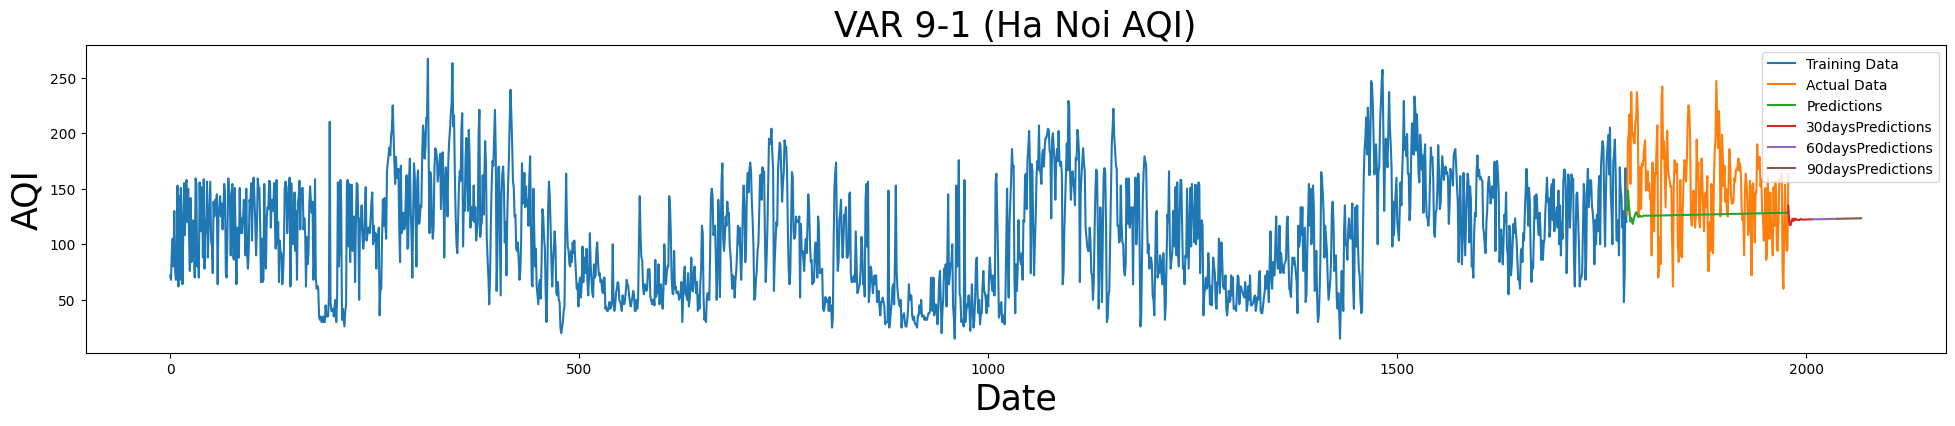

In [53]:
plt.figure(figsize=(24, 4))
plt.plot(train_data.index, train_data.AQI, label='Training Data')
plt.plot(test_data.index, test_data.AQI, label='Actual Data')
plt.plot(test_data.index, df_results.AQI_forecast, label='Predictions')  

plt.plot(prediect_data_index, df_results_30days.AQI_forecast, label='30daysPredictions')
plt.plot(predict_data_index_60, df_results_60days.AQI_forecast[-30:], label='60daysPredictions')
plt.plot(predict_data_index_90, df_results_90days.AQI_forecast[-30:], label='90daysPredictions')

plt.title('VAR 9-1 (Ha Noi AQI)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('AQI', fontsize=25)
plt.legend()
plt.show()

In [36]:
y_test = test_data.AQI
y_pred = df_results.AQI_forecast

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAPE: {mape:.2f}%')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAPE: 24.76%
MAE: 36.96
RMSE: 44.87
